# Parsing assembly and data processing results for PacBio and Illumina sequencing

### Maximillian Marin
### mgmarin@g.harvard.edu


### Import Statements

In [1]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

In [2]:
from Bio import SeqIO


### Set matplotlib text export settings for Adobe Illustrator

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Pandas Viewing Settings

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Define functions

In [5]:
def fromGBK_CountNumCDSFeautures(inputGBK_PATH):
    listOf_CDS_Features = []
    
    for record in SeqIO.parse(inputGBK_PATH, 'genbank'):
        for feat in record.features:
            if feat.type == 'CDS':
                listOf_CDS_Features.append(feat)
    
    num_CDS = len(listOf_CDS_Features)
    
    return num_CDS

In [6]:
gc_content = lambda s: 100.0*len([c for c in s if c in "GC"]) / len(s)

def fromGBK_CalcGCcontent(inputGBK_PATH):
    listOf_CDS_Features = []
    
    WholeGenome_GCcontent = 0
    
    for record in SeqIO.parse(inputGBK_PATH, 'genbank'):   
        if len(record.seq) > 100000:
            WholeGenome_GCcontent = gc_content( record.seq )

    return WholeGenome_GCcontent

In [7]:
#!ls -l $Repo_DataDir

### Parse  Sample Info w/ PATHs TSV to get sample names

In [8]:
Repo_DataDir = "../../Data"

TB_Portals_MainDir = f"{Repo_DataDir}/TB_Portals_Data"
TB_Portals_Genomic_Metadata_Dir = f"{TB_Portals_MainDir}/201021_TB_Portals_Genomic_And_DST_MetaData"
TB_Portals_Genomic_TargetIsolate_SRA_RunIDs_Dir = f"{TB_Portals_MainDir}/201123_TB_Portals_MtbIsolates_With_PacBio_And_Illumina_WGS"       


PMP_SM_50CI_SampleInfoTSVs_Dir = Repo_DataDir + "/201202_PMP_SM_50CI_AllDataSets_Wi_TB_Portals"



In [9]:
#!ls -lah $PMP_SM_50CI_SampleInfoTSVs_Dir

In [10]:
Repo_DataDir = "../../Data"

PMP_SM_50CI_SampleInfoTSVs_Dir = Repo_DataDir + "/201202_PMP_SM_50CI_AllDataSets_Wi_TB_Portals"

TB_Portals_50CI_IlluminaOnly_Round1_SampleInfo_TSV_PATH = f"{PMP_SM_50CI_SampleInfoTSVs_Dir}/201202_MTb_50CI_Peru_ChinerOms_Ngabonziza_TBPortals_PacBioDatasetsMerged_SampleInfo_InputFQs.tsv"  

TB_50CI_SampleInfo_InputReads_PATHs_DF = pd.read_csv(TB_Portals_50CI_IlluminaOnly_Round1_SampleInfo_TSV_PATH,
                                              sep = "\t")

PMP_R1_50CI_SampleID_To_Dataset_Dict = dict( TB_50CI_SampleInfo_InputReads_PATHs_DF[["SampleID", "Dataset_Tag"]].values)

TBP_R1_50CI_SampleIDs = list( TB_50CI_SampleInfo_InputReads_PATHs_DF["SampleID"].values )

# Remove N0052 b/c there is definitely a sample mix up
TBP_R1_49CI_SampleIDs = list(TBP_R1_50CI_SampleIDs)
TBP_R1_49CI_SampleIDs.remove("N0052")

#TBP_R1_50CI_SampleIDs_WiExtras.remove("N0145")
#TBP_R1_50CI_SampleIDs_WiExtras.remove("02_R0848")
#TBP_R1_50CI_SampleIDs_WiExtras.remove("02_R1708")
#TBP_R1_50CI_SampleIDs_WiExtras.remove("M0017522_5")
#TBP_R1_50CI_SampleIDs_WiExtras.remove("N1177")
#TBP_R1_50CI_SampleIDs_WiExtras.remove("N0091")



In [11]:
TB_50CI_SampleInfo_InputReads_PATHs_DF.shape

(50, 4)

In [12]:
len(TBP_R1_49CI_SampleIDs)

49

In [13]:
TB_50CI_SampleInfo_InputReads_PATHs_DF.shape

(50, 4)

In [14]:
TB_50CI_SampleInfo_InputReads_PATHs_DF.head(3)

,SampleID,PacBio_FQ_PATH,Illumina_PE_FQs_PATH,Dataset_Tag
0,M0011368_9,/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio...,/n/data1/hms/dbmi/farhat/fastq_db/cetr/Peru293...,Farhat_Peru_2019
1,M0014888_3,/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio...,/n/data1/hms/dbmi/farhat/fastq_db/cetr/Peru296...,Farhat_Peru_2019
2,M0015765_2,/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio...,/n/data1/hms/dbmi/farhat/fastq_db/cetr/Peru297...,Farhat_Peru_2019


### Parse TB Portals genomic metadata (for all TB Portals samples)

In [15]:
#TB_Portals_Genomic_CSV = f"{TB_Portals_Genomic_Metadata_Dir}/TB Portals_Genomics_20201021.csv"

In [16]:
#TB_Portals_Genomic_DF = pd.read_csv(TB_Portals_Genomic_CSV)
#TB_Portals_Genomic_DF.shape

# Define output directory of the data processing pipeline (using Snakemake)

In [17]:
# Define varaint calling pipeline output directories

PacBio_ProjectDir = "/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio_Evaluation_Project"

PMP_SM_Outputs_Dir = PacBio_ProjectDir + "/PacmanPipe_SM_Outputs"

PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir = PMP_SM_Outputs_Dir + "/201201_PMP_SM_TB_Portals_R1_Output_V2"


In [18]:
!ls -alh $PMP_SM_Outputs_Dir

total 224K
drwxr-sr-x   7 mm774 farhat  343 Mar 25 01:02 .
drwxrwsr-x  48 mm774 farhat 3.6K Mar 25 10:23 ..
drwxr-sr-x 100 mm774 farhat 2.7K Nov 24 20:42 191203_PMP_SM_All_Mtb_PacBioDatasetsMergedsample_Output
drwxrwsr-x  39 mm774 farhat  918 Aug 13  2020 200813_PMP_SM_MTb_35CI_Peru_ChinerOms_Ngabonziza_PacBioDatasetsMergedsample_Output
drwxrwsr-x  20 mm774 farhat  512 Nov 25 11:13 201124_PMP_SM_TB_Portals_R1_Output
drwxrwsr-x  72 mm774 farhat 1.8K Feb 22 19:43 201201_PMP_SM_TB_Portals_R1_Output_V2
drwxrwsr-x   2 mm774 farhat    0 Mar 25 01:02 201201_PMP_SM_TB_Portals_R1_Output_V2_NotReal


## Let's look at outcomes for the 50 clinical isolates from the Peru and ChinerOms datasets

In [19]:
### Outline of data to collect from each isolate:
#### 1)
#### 2)
#### 3)

In [20]:
complete_Circ_Genome_Counter = 0 

listOf_SampleIDs_PBvsI_CompletedCircular = []


listOf_SampleInfoTuples = []

i = 1
for SampleID in tqdm( TBP_R1_50CI_SampleIDs ) :  #["RW-TB008"]
    
    
    #print(i, SampleID)
    
    Sample_Output_Dir = f"{PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir}/{SampleID}"
    
    Sample_Pacbio_Dir = f"{Sample_Output_Dir}/pacbio"


    #### Lineage Calling #####
    #!ls -lah $Sample_Output_Dir #/LineageCalling/
    
    Sample_LineCall_IlluminaWGS_Pilon_TXT = f"{Sample_Output_Dir}/LineageCalling/LineageCall_IlluminaWGS_AlignTo_H37rv/{SampleID}.IlluminaWGS.Pilon.lineage_call.Coll.txt"
    Sample_LineCall_PBonly_MM2_TXT = f"{Sample_Output_Dir}/LineageCalling/LineageCall_Flye_I3_PBonly_MM2_AlignTo_H37rv/{SampleID}.AtoRef.Flye_I3_PBonly.lineage_call.Coll.txt"             
    Sample_LineCall_PP_MM2_TXT = f"{Sample_Output_Dir}/LineageCalling/LineageCall_Flye_I3_PP_MM2_AlignTo_H37rv/{SampleID}.AtoRef.FlyeI3_PP.lineage_call.Coll.txt"
    
    
    LineageCall_Illumina_SNPs = !head $Sample_LineCall_IlluminaWGS_Pilon_TXT
    LineageCall_PacBio_Only_SNPs   = !head $Sample_LineCall_PBonly_MM2_TXT
    LineageCall_PacBio_Illumina_Polished_SNPs = !head $Sample_LineCall_PP_MM2_TXT
    



    if SampleID == "RW-TB008":
        LineageCall_Illumina_SNPs = ["lineage8"]
        LineageCall_PacBio_Only_SNPs = ["lineage8"]    
        LineageCall_PacBio_Illumina_Polished_SNPs = ["lineage8"]    

    #############################
    
    

    
    ##### Evaluating Assembly Characteristics #####
    
    Flye_Assembly_Dir = f"{Sample_Pacbio_Dir}/Flye_Assembly"
    
    Assembly_Info_TXT = f"{Flye_Assembly_Dir}/assembly_info.txt"
    
    flye_assembly_LOG_PATH = f"{Flye_Assembly_Dir}/flye.log"
    
    CircContigs_TXT = f"{Flye_Assembly_Dir}/circularContigs_List.txt"
    NotCircContigs_TXT = f"{Flye_Assembly_Dir}/NoncircularContigs_List.txt"

    AI_DF = pd.read_csv(Assembly_Info_TXT, sep = "\t")

    AI_DF_CircCompleteOnly = AI_DF[ (AI_DF["circ."] == "+") & (AI_DF["length"] >= 4300000) ]
    
    numContigs_Complete = AI_DF_CircCompleteOnly.shape[0]
    
    
    if len(AI_DF_CircCompleteOnly["length"].values) > 0:
        circContig_Length = AI_DF_CircCompleteOnly["length"].values[0]
        circContig_Cov = AI_DF_CircCompleteOnly["cov."].values[0]
    else:
        circContig_Length = 0
        circContig_Cov = 0
    
    if numContigs_Complete == 1:
        complete_Circ_Genome_Counter += 1
    
        listOf_SampleIDs_PBvsI_CompletedCircular.append(SampleID)

    #####################################

    
    
    
    
    
    Sample_Prokka_MainDir = f"{Sample_Output_Dir}/Prokka"
    
    Sample_Prokka_PB_DeNovo_Dir = f"{Sample_Prokka_MainDir}/Flye_I3_PB_DeNovo_Prokka_Anno"
    Sample_Prokka_PB_PP_Dir = f"{Sample_Prokka_MainDir}/Flye_I3_PB_PilonPolished_Prokka_Anno"

    Sample_Prokka_PB_DeNovo_GBK = f"{Sample_Prokka_PB_DeNovo_Dir}/{SampleID}.gbk"
    Sample_Prokka_PB_PP_GBK = f"{Sample_Prokka_PB_PP_Dir}/{SampleID}.gbk"
    
    NumAnno_ORFs_PB_PilonPolished = fromGBK_CountNumCDSFeautures(Sample_Prokka_PB_PP_GBK)
    NumAnno_ORFs_PB_DeNovo = fromGBK_CountNumCDSFeautures(Sample_Prokka_PB_DeNovo_GBK)
    
    GCcontent_PB_PP_GBK = fromGBK_CalcGCcontent(Sample_Prokka_PB_PP_GBK)
    
    
    

    ##### Assembly ANI to H37Rv #####
    
    FastANI_I3_Output_TXT = f"{Sample_Pacbio_Dir}/FastANI_OutputDirs/FlyeAssembly_I3_PBonly_FastANI/{SampleID}.flyeassembly.I3.AssemblyToH37rv.FastANI.txt"
    FastANI_I3_PP_Output_TXT = f"{Sample_Pacbio_Dir}/FastANI_OutputDirs/Flye_I3_PilonPolished_FastANI/{SampleID}_I3_PP_AssemblyToH37rv.FastANI.txt"

    ANI_I3 = pd.read_csv(FastANI_I3_Output_TXT, sep = "\t", names = ["InputAssembly", "H37rv", "ANI", "N_ORFs_1", "N_ORFs_2"])["ANI"].values[0]
    ANI_I3_PP = pd.read_csv(FastANI_I3_PP_Output_TXT, sep = "\t", names = ["InputAssembly", "H37rv", "ANI", "N_ORFs_1", "N_ORFs_2"])["ANI"].values[0]

    #############################

    
    
    # Get approximate Illumina WGS coverage to H37rv (From depth.averaged.txt)  M0011368_9.IllPE.H37rv.duprem.bam.depth.txt
    sample_IlluminaWGSToH37rv_CovAveraged_TXT = f"{Sample_Output_Dir}/IlluminaWGS/IlluminaPE_AlignedTo_H37rv/{SampleID}.IllPE.H37rv.duprem.bam.depth.averaged.txt"

    IlluminaWGSToH37rv_CovAveraged_Line = !head -n 1 $sample_IlluminaWGSToH37rv_CovAveraged_TXT
    IlluminaWGSToH37rv_AvrgCov = int(float(IlluminaWGSToH37rv_CovAveraged_Line[0].split(" ")[-1].strip()))
    
    
    
    
    # Get approximate PacBio subread depth to H37rv (From depth.averaged.txt)
    sample_SubreadsToH37rv_CovAveraged_TXT = f"{Sample_Output_Dir}/pacbio_VariantCallingVersusH37Rv/PacBio_Subreads_AlignedToH37Rv_Minimap2/{SampleID}.pb.subreads.H37Rv.minimap2.bam.depth.averaged.txt"    

    SubreadsToH37Rv_DepthAveraged_Line = !head -n 1 $sample_SubreadsToH37rv_CovAveraged_TXT
    
    PacBio_Subreads_H37Rv_AvrgCov = int(float(SubreadsToH37Rv_DepthAveraged_Line[0].split(" ")[-1].strip()))
    

    
    Sample_Nanoplot_QC_Dir = f"{Sample_Pacbio_Dir}/Nanoplot_QC/{SampleID}.subreads.NanoPlot"
    
    i_Nanoplot_QC_Stats_TXT = f"{Sample_Nanoplot_QC_Dir}/NanoStats.txt"
    
    #!grep "Median read length:" $i_Nanoplot_QC_Stats_TXT
    
    Nanoplot_MedianReadLength_Line = !head $i_Nanoplot_QC_Stats_TXT | grep "Median read length"
    i_MedianReadLength_bp = float(Nanoplot_MedianReadLength_Line[0].split(":")[-1].strip().replace(",",""))
    
    #print(i_MedianReadLength_bp)

    
    
    ###### Evaluating Pilon Polishing Changes ######

    sample_Pilon_OutputDir = f"{Sample_Output_Dir}/FlyeAssembly_I3_IlluminaPolishing/pilon_IllPE_Polishing_I3_Assembly_ChangeSNPsINDELsOnly/"

    
    Ill_Pilon_Changes_PATH = sample_Pilon_OutputDir + f"/{SampleID}.Flye.I3Assembly.PilonPolished.changes"
    
    NumSNPs_PilonPolished = !awk -F ' ' '($3 != ".") && ($4 != ".") && (length($3) == 1) && (length($4) == 1)' $Ill_Pilon_Changes_PATH | wc -l 
    NumSNPs_PilonPolished = int( NumSNPs_PilonPolished[0] )

    NumChanges_PilonPolished = !wc -l $Ill_Pilon_Changes_PATH | cut -d' ' -f 1
    NumChanges_PilonPolished = int( NumChanges_PilonPolished[0] )
    
    Num1bpInsertion_PilonPolished = !awk -F ' ' '($3 == ".") && ($4 != ".") && (length($3) == length($4))' $Ill_Pilon_Changes_PATH | wc -l # Check for Insertions
    Num2bpInsertion_PilonPolished = !awk -F ' ' '($3 == ".") && ($4 != ".") && (length($4) == 2)' $Ill_Pilon_Changes_PATH | wc -l
    NumTotalInsertions_PilonPolished = !awk -F ' ' '($3 == ".") && ($4 != ".") ' $Ill_Pilon_Changes_PATH | wc -l # Check for Insertions
    NumTotalDeletions_PilonPolished = !awk -F ' ' '($3 != ".") && ($4 == ".") ' $Ill_Pilon_Changes_PATH | wc -l # Check for Deletions    
    Num1bpDeletion_PilonPolished = !awk -F ' ' '($3 != ".") && ($4 == ".") && (length($3) == 1)' $Ill_Pilon_Changes_PATH | wc -l # Check for Deletions    

    
    #####################################

    
    
    ############ F2 Metric #################
    
    sample_F2_Illumina_TXT = f"{Sample_Output_Dir}/IlluminaWGS/F2_Calculation/{SampleID}_F2.txt"
    
    sample_F2_PacBio_TXT = f"{Sample_Output_Dir}/pacbio_VariantCallingVersusH37Rv/F2_Calculation/{SampleID}_F2.txt"
    
    sample_F2_Illumina_Score = pd.read_csv(sample_F2_Illumina_TXT, header = None).values[0][0]

    sample_F2_PacBio_Score = pd.read_csv(sample_F2_PacBio_TXT, header = None).values[0][0]

    
    
    ########################################

    
    
       



    sampleInfo_Tuple = (SampleID,
                        numContigs_Complete,
                        circContig_Length,
                        circContig_Cov,
                        i_MedianReadLength_bp,  
                        LineageCall_Illumina_SNPs[0],
                        LineageCall_PacBio_Only_SNPs[0],
                        sample_F2_Illumina_Score,
                        sample_F2_PacBio_Score,
                        ANI_I3,
                        ANI_I3_PP,
                        IlluminaWGSToH37rv_AvrgCov,
                        PacBio_Subreads_H37Rv_AvrgCov,
                        NumAnno_ORFs_PB_PilonPolished,
                        NumAnno_ORFs_PB_DeNovo,
                        GCcontent_PB_PP_GBK,
                        NumChanges_PilonPolished,
                        NumSNPs_PilonPolished,
                        int(NumTotalInsertions_PilonPolished[0] ),
                        int(Num1bpInsertion_PilonPolished[0] ),
                        int(Num2bpInsertion_PilonPolished[0] ),
                        int(NumTotalDeletions_PilonPolished[0]),
                        int(Num1bpDeletion_PilonPolished[0]),
                        )
    
    listOf_SampleInfoTuples.append(sampleInfo_Tuple)
    
    
    #print(SampleID, LineageCall_Illumina_SNPs[0])
    
    
    #print()
    i += 1
    #break
    
    
print("# of complete circular genomes", complete_Circ_Genome_Counter)

    
    
PMP_50CI_AssemblySummary = pd.DataFrame(listOf_SampleInfoTuples)
PMP_50CI_AssemblySummary.columns = ["SampleID",
                                   "numContigs_Complete",
                                   "circContig_Length",
                                   "circContig_Cov",
                                   "PacBio_Subread_Median_Length", 
                                   "LineageCall_Illumina", 
                                   "LineageCall_PacBio",
                                    "F2_Illumina",
                                    "F2_PacBio",
                                    "ANI_I3",
                                    "ANI_I3_PP",
                                    "IlluminaWGSToH37rv_AvrgCov",
                                    "PacBio_Subreads_H37Rv_AvrgCov",
                                    "NumAnno_ORFs_PB_PilonPolished",
                                    "NumAnno_ORFs_PB_DeNovo",
                                    "GCcontent_PB_PP_GBK",
                                   "NumChanges_PilonPolished",
                                   "NumSNPs_PilonPolished",
                                   "NumTotalInsertions_PilonPolished",
                                   "Num1bpInsertion_PilonPolished",
                                   "Num2bpInsertion_PilonPolished",
                                   "NumTotalDeletions_PilonPolished",
                                   "Num1bpDeletion_PilonPolished", ]



PMP_50CI_AssemblySummary["PrimaryLineage_PB"] = PMP_50CI_AssemblySummary["LineageCall_PacBio"].str.split(",").str[0]
PMP_50CI_AssemblySummary["PrimaryLineage_Ill"] = PMP_50CI_AssemblySummary["LineageCall_Illumina"].str.split(",").str[0]
PMP_50CI_AssemblySummary['Dataset_Tag'] = PMP_50CI_AssemblySummary.SampleID.map(PMP_R1_50CI_SampleID_To_Dataset_Dict)


100%|██████████| 50/50 [03:13<00:00,  3.85s/it]

# of complete circular genomes 47


In [21]:
ID_To_IlluminaAvrgCov_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'IlluminaWGSToH37rv_AvrgCov']].values)                     
ID_To_Lineage_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'PrimaryLineage_PB']].values)
ID_To_Dataset_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'Dataset_Tag']].values)  

# Filtering Samples

In [22]:
# Let's take a look at all 50 processed samples
PMP_50CI_AssemblySummary

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
0,M0011368_9,1,4397765,203,3773.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.004937,0.305222,99.9368,99.9364,40,191,4050,4075,65.614721,63,0,59,58,1,4,4,lineage4,lineage4,Farhat_Peru_2019
1,M0014888_3,1,4399966,194,5038.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.007132,0.279607,99.9185,99.9193,77,182,4048,4060,65.635971,39,0,39,39,0,0,0,lineage4,lineage4,Farhat_Peru_2019
2,M0015765_2,1,4386618,172,2735.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002126,0.442765,99.9345,99.9377,122,161,4032,4086,65.618696,111,10,93,93,0,8,7,lineage4,lineage4,Farhat_Peru_2019
3,M0016395_7,1,4420916,195,4621.0,"lineage4,lineage4.3,lineage4.3.2","lineage4,lineage4.3,lineage4.3.2",0.003671,0.299199,99.9248,99.9262,43,183,4068,4096,65.615829,71,1,66,65,1,4,4,lineage4,lineage4,Farhat_Peru_2019
4,M0010874_7,1,4396274,172,4675.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002880,0.289791,99.9283,99.9310,89,161,4054,4103,65.614744,111,9,95,95,0,7,6,lineage4,lineage4,Farhat_Peru_2019
5,01_R1430,1,4409128,227,6009.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.005372,0.295069,99.9284,99.9290,253,212,4070,4119,65.613390,93,0,90,89,0,3,3,lineage4,lineage4,Farhat_Peru_2019
6,02_R0848,0,0,0,4908.0,"lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1","lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1",0.009652,0.318674,99.9197,99.9290,175,156,4078,4246,65.634370,356,0,356,355,1,0,0,lineage4,lineage4,Farhat_Peru_2019
7,02_R0894,1,4422314,191,4836.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.013648,0.304220,99.9224,99.9284,141,178,4076,4180,65.635659,190,0,189,188,1,1,1,lineage4,lineage4,Farhat_Peru_2019
8,02_R1675,1,4411443,164,5525.0,lineage4,lineage4,0.077580,0.226546,99.9348,99.9339,52,155,4059,4071,65.606908,31,0,31,30,0,0,0,lineage4,lineage4,Farhat_Peru_2019
9,02_R1708,1,4426275,193,5907.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.006856,0.328144,99.9152,99.9136,163,177,4078,4384,65.629736,735,0,731,730,0,4,4,lineage4,lineage4,Farhat_Peru_2019


## A) Remove SampleID **N0052** b/c of a clear sample mix up

#### The # of SNPs corrected is extremely high and the lineage predictions are different between Illumina and WGS

## Therefore, we suspect that the PacBio WGS was not performed on the sample isolate as Illumina WGS.


"Sample with evidence of sample mix ups between PacBio and long read sequencing, samples with evidence of mixed infections, and samples with low Illumina WGS depth (<40) were excluded from analysis"


In [23]:
PMP_49CI_AssemblySummary = PMP_50CI_AssemblySummary[PMP_50CI_AssemblySummary["SampleID"] != "N0052"]

In [24]:
PMP_50CI_AssemblySummary[ (PMP_50CI_AssemblySummary["numContigs_Complete"] == 1) ].shape

(47, 26)

In [25]:
PMP_49CI_AssemblySummary[ (PMP_49CI_AssemblySummary["numContigs_Complete"] == 1) ].shape

(46, 26)

## B) Remove samples with evidence of mixed populations @ lineage defining positions (High F2 score)

In [26]:
PMP_49CI_AssemblySummary.sort_values("F2_Illumina", ascending=False).head(8)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
38,AZE_02_047,0,0,0,5196.0,,"lineage2,lineage2.2,lineage2.2.1",0.451540,0.483134,99.9021,99.8983,95,121,4102,4123,65.004362,129,27,13,11,1,89,77,lineage2,,TB_Portals_15CI_R1
42,DNA017,1,4406756,428,5813.0,lineage4,"lineage4,lineage4.8",0.370357,0.303290,99.9452,99.9456,45,410,4063,4091,65.608336,68,10,7,7,0,51,47,lineage4,lineage4,TB_Portals_15CI_R1
8,02_R1675,1,4411443,164,5525.0,lineage4,lineage4,0.077580,0.226546,99.9348,99.9339,52,155,4059,4071,65.606908,31,0,31,30,0,0,0,lineage4,lineage4,Farhat_Peru_2019
48,DNA097,1,4392132,559,5894.0,"lineage4,lineage4.8","lineage4,lineage4.8",0.059543,0.247264,99.9519,99.9530,41,536,4029,4052,65.618663,40,0,3,3,0,37,37,lineage4,lineage4,TB_Portals_15CI_R1
12,M0017522_5,1,4416217,163,3891.0,"lineage4,lineage4.1,lineage4.1.1","lineage4,lineage4.1,lineage4.1.1",0.032894,0.318561,99.9139,99.9293,75,151,4057,4272,65.616165,503,0,499,497,1,4,4,lineage4,lineage4,Farhat_Peru_2019
32,N1202,1,4391653,362,2202.0,"lineage6,lineageBOV_AFRI","lineage6,lineageBOV_AFRI",0.023740,0.287361,99.8719,99.8749,96,347,4027,4034,65.596049,19,1,3,3,0,15,15,lineage6,lineage6,ChinerOms_2019
19,N0153,1,4389210,372,2027.0,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1","lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",0.023551,0.272487,99.8687,99.8692,98,370,4037,4043,65.612081,53,19,2,1,1,32,32,lineage1,lineage1,ChinerOms_2019
30,N1272,1,4421156,370,2565.0,lineage5,lineage5,0.023518,0.283543,99.8775,99.8783,74,355,4088,4092,65.587884,41,1,1,0,0,39,39,lineage5,lineage5,ChinerOms_2019


In [27]:
PMP_49CI_AssemblySummary.sort_values("F2_PacBio", ascending=False).head(8)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
38,AZE_02_047,0,0,0,5196.0,,"lineage2,lineage2.2,lineage2.2.1",0.451540,0.483134,99.9021,99.8983,95,121,4102,4123,65.004362,129,27,13,11,1,89,77,lineage2,,TB_Portals_15CI_R1
2,M0015765_2,1,4386618,172,2735.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002126,0.442765,99.9345,99.9377,122,161,4032,4086,65.618696,111,10,93,93,0,8,7,lineage4,lineage4,Farhat_Peru_2019
14,M0003941_3,1,4420723,206,5023.5,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.011555,0.334658,99.8797,99.8952,273,189,4093,4268,65.609616,453,0,449,448,1,4,4,lineage2,lineage2,Farhat_Peru_2019
9,02_R1708,1,4426275,193,5907.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.006856,0.328144,99.9152,99.9136,163,177,4078,4384,65.629736,735,0,731,730,0,4,4,lineage4,lineage4,Farhat_Peru_2019
10,02_R1896,1,4406804,195,5385.0,"lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1","lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1",0.005804,0.321782,99.9156,99.9216,117,179,4068,4295,65.609996,501,0,499,496,3,2,2,lineage4,lineage4,Farhat_Peru_2019
6,02_R0848,0,0,0,4908.0,"lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1","lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1",0.009652,0.318674,99.9197,99.9290,175,156,4078,4246,65.634370,356,0,356,355,1,0,0,lineage4,lineage4,Farhat_Peru_2019
12,M0017522_5,1,4416217,163,3891.0,"lineage4,lineage4.1,lineage4.1.1","lineage4,lineage4.1,lineage4.1.1",0.032894,0.318561,99.9139,99.9293,75,151,4057,4272,65.616165,503,0,499,497,1,4,4,lineage4,lineage4,Farhat_Peru_2019
11,M0016737_0,1,4431421,162,5691.0,"lineage4,lineage4.5","lineage4,lineage4.5",0.005269,0.307715,99.9452,99.9460,96,151,4096,4142,65.619514,92,0,88,86,1,4,4,lineage4,lineage4,Farhat_Peru_2019


In [28]:
PMP_49CI_AssemblySummary[ (PMP_49CI_AssemblySummary["F2_Illumina"] < 0.05) & (PMP_49CI_AssemblySummary["F2_PacBio"] < 0.35) ].shape

(44, 26)

In [29]:
PMP_49CI_AssemblySummary[ (PMP_49CI_AssemblySummary["F2_Illumina"] < 0.05) & (PMP_49CI_AssemblySummary["F2_PacBio"] < 0.35) ].head(5)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
0,M0011368_9,1,4397765,203,3773.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.004937,0.305222,99.9368,99.9364,40,191,4050,4075,65.614721,63,0,59,58,1,4,4,lineage4,lineage4,Farhat_Peru_2019
1,M0014888_3,1,4399966,194,5038.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.007132,0.279607,99.9185,99.9193,77,182,4048,4060,65.635971,39,0,39,39,0,0,0,lineage4,lineage4,Farhat_Peru_2019
3,M0016395_7,1,4420916,195,4621.0,"lineage4,lineage4.3,lineage4.3.2","lineage4,lineage4.3,lineage4.3.2",0.003671,0.299199,99.9248,99.9262,43,183,4068,4096,65.615829,71,1,66,65,1,4,4,lineage4,lineage4,Farhat_Peru_2019
4,M0010874_7,1,4396274,172,4675.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002880,0.289791,99.9283,99.9310,89,161,4054,4103,65.614744,111,9,95,95,0,7,6,lineage4,lineage4,Farhat_Peru_2019
5,01_R1430,1,4409128,227,6009.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.005372,0.295069,99.9284,99.9290,253,212,4070,4119,65.613390,93,0,90,89,0,3,3,lineage4,lineage4,Farhat_Peru_2019


In [30]:
PMP_49CI_AssemblySummary[ (PMP_49CI_AssemblySummary["F2_Illumina"] < 0.05) & (PMP_49CI_AssemblySummary["F2_PacBio"] < 0.35) ].sort_values("IlluminaWGSToH37rv_AvrgCov").head(8)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
29,N1283,1,4420512,316,2566.0,"lineage4,lineage4.2,lineage4.2.1","lineage4,lineage4.2,lineage4.2.1",0.005568,0.255956,99.9146,99.9169,26,325,4066,4068,65.588092,22,3,0,0,0,19,19,lineage4,lineage4,ChinerOms_2019
28,N0136,1,4396720,325,2425.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.010194,0.262983,99.9261,99.9265,28,322,4046,4053,65.616247,16,1,7,7,0,8,8,lineage4,lineage4,ChinerOms_2019
27,N1216,1,4393769,244,3024.0,"lineage4,lineage4.6,lineage4.6.2,lineage4.6.2.2","lineage4,lineage4.6,lineage4.6.2,lineage4.6.2.2",0.006912,0.243559,99.9304,99.9306,34,234,4061,4065,65.607672,12,0,1,1,0,11,11,lineage4,lineage4,ChinerOms_2019
39,DNA033,1,4438616,951,7056.0,"lineage4,lineage4.2,lineage4.2.1","lineage4,lineage4.2,lineage4.2.1",0.011326,0.266380,99.9156,99.9168,37,1101,4091,4108,65.604457,41,1,1,1,0,39,39,lineage4,lineage4,TB_Portals_15CI_R1
17,N0157,1,4410940,336,2264.0,"lineage1,lineage1.2.1","lineage1,lineage1.2.1",0.007377,0.272175,99.8782,99.8786,38,327,4059,4063,65.618808,14,3,3,2,1,8,7,lineage1,lineage1,ChinerOms_2019
45,DNA011,1,4417355,278,5561.0,lineage4,lineage4,0.003759,0.187812,99.9360,99.9370,39,267,4069,4085,65.592781,56,7,8,7,1,41,41,lineage4,lineage4,TB_Portals_15CI_R1
0,M0011368_9,1,4397765,203,3773.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.004937,0.305222,99.9368,99.9364,40,191,4050,4075,65.614721,63,0,59,58,1,4,4,lineage4,lineage4,Farhat_Peru_2019
3,M0016395_7,1,4420916,195,4621.0,"lineage4,lineage4.3,lineage4.3.2","lineage4,lineage4.3,lineage4.3.2",0.003671,0.299199,99.9248,99.9262,43,183,4068,4096,65.615829,71,1,66,65,1,4,4,lineage4,lineage4,Farhat_Peru_2019


### "Mixed infections were detected for both PacBio and Illumina sequencing using the F2 metric, looking at heregnetity of base calls at known lineage defining positions" 

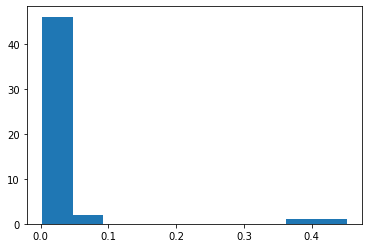

count    50.000000
mean      0.029077
std       0.080260
min       0.002126
25%       0.006050
50%       0.009776
75%       0.014649
max       0.451540
Name: F2_Illumina, dtype: float64

In [31]:
plt.hist(PMP_50CI_AssemblySummary["F2_Illumina"])

plt.show()
PMP_50CI_AssemblySummary["F2_Illumina"].describe()

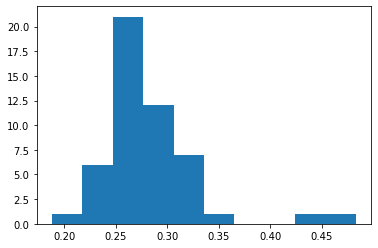

count    50.000000
mean      0.281968
std       0.048043
min       0.187812
25%       0.254145
50%       0.270054
75%       0.302267
max       0.483134
Name: F2_PacBio, dtype: float64

In [32]:
plt.hist(PMP_50CI_AssemblySummary["F2_PacBio"])

plt.show()
PMP_50CI_AssemblySummary["F2_PacBio"].describe()

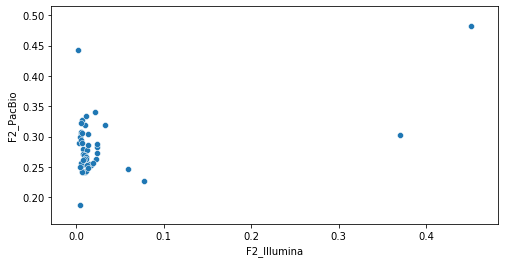

In [33]:
plt.figure( figsize = (8,4))
sns.scatterplot(x="F2_Illumina", y="F2_PacBio",
                data = PMP_50CI_AssemblySummary)

#plt.xlabel("PacBio X Coverage (to assembly)")
#plt.ylabel("# of erroneous 1 bp deletions (in de novo PacBio assembly)")

plt.show()

In [34]:
#PMP_50CI_AssemblySummary[ (PMP_50CI_AssemblySummary["numContigs_Complete"] == 1) ] 

#### Look at all 5 samples with evidence of mixed populations (In Illumina or PacBio)

In [35]:
PMP_49CI_AssemblySummary[ (PMP_49CI_AssemblySummary["F2_Illumina"] >= 0.05) | (PMP_49CI_AssemblySummary["F2_PacBio"] >= 0.35) ].sort_values("IlluminaWGSToH37rv_AvrgCov")  

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
48,DNA097,1,4392132,559,5894.0,"lineage4,lineage4.8","lineage4,lineage4.8",0.059543,0.247264,99.9519,99.9530,41,536,4029,4052,65.618663,40,0,3,3,0,37,37,lineage4,lineage4,TB_Portals_15CI_R1
42,DNA017,1,4406756,428,5813.0,lineage4,"lineage4,lineage4.8",0.370357,0.303290,99.9452,99.9456,45,410,4063,4091,65.608336,68,10,7,7,0,51,47,lineage4,lineage4,TB_Portals_15CI_R1
8,02_R1675,1,4411443,164,5525.0,lineage4,lineage4,0.077580,0.226546,99.9348,99.9339,52,155,4059,4071,65.606908,31,0,31,30,0,0,0,lineage4,lineage4,Farhat_Peru_2019
38,AZE_02_047,0,0,0,5196.0,,"lineage2,lineage2.2,lineage2.2.1",0.451540,0.483134,99.9021,99.8983,95,121,4102,4123,65.004362,129,27,13,11,1,89,77,lineage2,,TB_Portals_15CI_R1
2,M0015765_2,1,4386618,172,2735.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002126,0.442765,99.9345,99.9377,122,161,4032,4086,65.618696,111,10,93,93,0,8,7,lineage4,lineage4,Farhat_Peru_2019


In [36]:
PMP_44CI_F2Filt_AssemblySummary = PMP_49CI_AssemblySummary[ (PMP_49CI_AssemblySummary["F2_Illumina"] < 0.05) & (PMP_49CI_AssemblySummary["F2_PacBio"] < 0.35) ]

In [37]:
PMP_44CI_F2Filt_AssemblySummary.shape

(44, 26)

In [38]:
PMP_44CI_F2Filt_AssemblySummary[ (PMP_44CI_F2Filt_AssemblySummary["numContigs_Complete"] != 1) ]

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
6,02_R0848,0,0,0,4908.0,"lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1","lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1",0.009652,0.318674,99.9197,99.9290,175,156,4078,4246,65.634370,356,0,356,355,1,0,0,lineage4,lineage4,Farhat_Peru_2019
22,N0031,0,0,0,2615.0,"lineage2,lineage2.1","lineage2,lineage2.1",0.011798,0.277769,99.9137,99.9143,87,318,4033,4047,65.620575,26,0,0,0,0,26,25,lineage2,lineage2,ChinerOms_2019


In [39]:
PMP_44CI_F2Filt_AssemblySummary.head()

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
0,M0011368_9,1,4397765,203,3773.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.004937,0.305222,99.9368,99.9364,40,191,4050,4075,65.614721,63,0,59,58,1,4,4,lineage4,lineage4,Farhat_Peru_2019
1,M0014888_3,1,4399966,194,5038.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.007132,0.279607,99.9185,99.9193,77,182,4048,4060,65.635971,39,0,39,39,0,0,0,lineage4,lineage4,Farhat_Peru_2019
3,M0016395_7,1,4420916,195,4621.0,"lineage4,lineage4.3,lineage4.3.2","lineage4,lineage4.3,lineage4.3.2",0.003671,0.299199,99.9248,99.9262,43,183,4068,4096,65.615829,71,1,66,65,1,4,4,lineage4,lineage4,Farhat_Peru_2019
4,M0010874_7,1,4396274,172,4675.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002880,0.289791,99.9283,99.9310,89,161,4054,4103,65.614744,111,9,95,95,0,7,6,lineage4,lineage4,Farhat_Peru_2019
5,01_R1430,1,4409128,227,6009.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.005372,0.295069,99.9284,99.9290,253,212,4070,4119,65.613390,93,0,90,89,0,3,3,lineage4,lineage4,Farhat_Peru_2019


In [40]:
PMP_42CI_CicularOnly_AssemblySummary = PMP_44CI_F2Filt_AssemblySummary[ (PMP_44CI_F2Filt_AssemblySummary["numContigs_Complete"] == 1) ]

In [41]:
PMP_42CI_CicularOnly_AssemblySummary.shape

(42, 26)

In [42]:
PMP_42CI_CicularOnly_AssemblySummary.sort_values("IlluminaWGSToH37rv_AvrgCov").head(10)

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
29,N1283,1,4420512,316,2566.0,"lineage4,lineage4.2,lineage4.2.1","lineage4,lineage4.2,lineage4.2.1",0.005568,0.255956,99.9146,99.9169,26,325,4066,4068,65.588092,22,3,0,0,0,19,19,lineage4,lineage4,ChinerOms_2019
28,N0136,1,4396720,325,2425.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.010194,0.262983,99.9261,99.9265,28,322,4046,4053,65.616247,16,1,7,7,0,8,8,lineage4,lineage4,ChinerOms_2019
27,N1216,1,4393769,244,3024.0,"lineage4,lineage4.6,lineage4.6.2,lineage4.6.2.2","lineage4,lineage4.6,lineage4.6.2,lineage4.6.2.2",0.006912,0.243559,99.9304,99.9306,34,234,4061,4065,65.607672,12,0,1,1,0,11,11,lineage4,lineage4,ChinerOms_2019
39,DNA033,1,4438616,951,7056.0,"lineage4,lineage4.2,lineage4.2.1","lineage4,lineage4.2,lineage4.2.1",0.011326,0.266380,99.9156,99.9168,37,1101,4091,4108,65.604457,41,1,1,1,0,39,39,lineage4,lineage4,TB_Portals_15CI_R1
17,N0157,1,4410940,336,2264.0,"lineage1,lineage1.2.1","lineage1,lineage1.2.1",0.007377,0.272175,99.8782,99.8786,38,327,4059,4063,65.618808,14,3,3,2,1,8,7,lineage1,lineage1,ChinerOms_2019
45,DNA011,1,4417355,278,5561.0,lineage4,lineage4,0.003759,0.187812,99.9360,99.9370,39,267,4069,4085,65.592781,56,7,8,7,1,41,41,lineage4,lineage4,TB_Portals_15CI_R1
0,M0011368_9,1,4397765,203,3773.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.004937,0.305222,99.9368,99.9364,40,191,4050,4075,65.614721,63,0,59,58,1,4,4,lineage4,lineage4,Farhat_Peru_2019
3,M0016395_7,1,4420916,195,4621.0,"lineage4,lineage4.3,lineage4.3.2","lineage4,lineage4.3,lineage4.3.2",0.003671,0.299199,99.9248,99.9262,43,183,4068,4096,65.615829,71,1,66,65,1,4,4,lineage4,lineage4,Farhat_Peru_2019
49,DNA086,1,4391520,555,6987.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.007174,0.261074,99.9296,99.9305,44,532,4041,4058,65.597410,41,2,4,3,0,35,35,lineage4,lineage4,TB_Portals_15CI_R1
36,DNA075,1,4410963,753,7087.0,"lineage2,lineage2.2,lineage2.2.1","lineage2,lineage2.2,lineage2.2.1",0.009901,0.270275,99.8885,99.8895,46,715,4067,4087,65.614151,54,3,5,5,0,46,46,lineage2,lineage2,TB_Portals_15CI_R1


In [43]:
PMP_42CI_CicularOnly_AssemblySummary[  (PMP_42CI_CicularOnly_AssemblySummary["IlluminaWGSToH37rv_AvrgCov"] < 40)] 

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
17,N0157,1,4410940,336,2264.0,"lineage1,lineage1.2.1","lineage1,lineage1.2.1",0.007377,0.272175,99.8782,99.8786,38,327,4059,4063,65.618808,14,3,3,2,1,8,7,lineage1,lineage1,ChinerOms_2019
27,N1216,1,4393769,244,3024.0,"lineage4,lineage4.6,lineage4.6.2,lineage4.6.2.2","lineage4,lineage4.6,lineage4.6.2,lineage4.6.2.2",0.006912,0.243559,99.9304,99.9306,34,234,4061,4065,65.607672,12,0,1,1,0,11,11,lineage4,lineage4,ChinerOms_2019
28,N0136,1,4396720,325,2425.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.010194,0.262983,99.9261,99.9265,28,322,4046,4053,65.616247,16,1,7,7,0,8,8,lineage4,lineage4,ChinerOms_2019
29,N1283,1,4420512,316,2566.0,"lineage4,lineage4.2,lineage4.2.1","lineage4,lineage4.2,lineage4.2.1",0.005568,0.255956,99.9146,99.9169,26,325,4066,4068,65.588092,22,3,0,0,0,19,19,lineage4,lineage4,ChinerOms_2019
39,DNA033,1,4438616,951,7056.0,"lineage4,lineage4.2,lineage4.2.1","lineage4,lineage4.2,lineage4.2.1",0.011326,0.266380,99.9156,99.9168,37,1101,4091,4108,65.604457,41,1,1,1,0,39,39,lineage4,lineage4,TB_Portals_15CI_R1
45,DNA011,1,4417355,278,5561.0,lineage4,lineage4,0.003759,0.187812,99.9360,99.9370,39,267,4069,4085,65.592781,56,7,8,7,1,41,41,lineage4,lineage4,TB_Portals_15CI_R1


In [44]:
PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary = PMP_42CI_CicularOnly_AssemblySummary[  (PMP_42CI_CicularOnly_AssemblySummary["IlluminaWGSToH37rv_AvrgCov"] >= 40)] 

In [45]:
PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary.shape

(36, 26)

In [46]:
PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
0,M0011368_9,1,4397765,203,3773.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.004937,0.305222,99.9368,99.9364,40,191,4050,4075,65.614721,63,0,59,58,1,4,4,lineage4,lineage4,Farhat_Peru_2019
1,M0014888_3,1,4399966,194,5038.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.007132,0.279607,99.9185,99.9193,77,182,4048,4060,65.635971,39,0,39,39,0,0,0,lineage4,lineage4,Farhat_Peru_2019
3,M0016395_7,1,4420916,195,4621.0,"lineage4,lineage4.3,lineage4.3.2","lineage4,lineage4.3,lineage4.3.2",0.003671,0.299199,99.9248,99.9262,43,183,4068,4096,65.615829,71,1,66,65,1,4,4,lineage4,lineage4,Farhat_Peru_2019
4,M0010874_7,1,4396274,172,4675.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002880,0.289791,99.9283,99.9310,89,161,4054,4103,65.614744,111,9,95,95,0,7,6,lineage4,lineage4,Farhat_Peru_2019
5,01_R1430,1,4409128,227,6009.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.005372,0.295069,99.9284,99.9290,253,212,4070,4119,65.613390,93,0,90,89,0,3,3,lineage4,lineage4,Farhat_Peru_2019
7,02_R0894,1,4422314,191,4836.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.013648,0.304220,99.9224,99.9284,141,178,4076,4180,65.635659,190,0,189,188,1,1,1,lineage4,lineage4,Farhat_Peru_2019
9,02_R1708,1,4426275,193,5907.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.006856,0.328144,99.9152,99.9136,163,177,4078,4384,65.629736,735,0,731,730,0,4,4,lineage4,lineage4,Farhat_Peru_2019
10,02_R1896,1,4406804,195,5385.0,"lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1","lineage4,lineage4.4,lineage4.4.1,lineage4.4.1.1",0.005804,0.321782,99.9156,99.9216,117,179,4068,4295,65.609996,501,0,499,496,3,2,2,lineage4,lineage4,Farhat_Peru_2019
11,M0016737_0,1,4431421,162,5691.0,"lineage4,lineage4.5","lineage4,lineage4.5",0.005269,0.307715,99.9452,99.9460,96,151,4096,4142,65.619514,92,0,88,86,1,4,4,lineage4,lineage4,Farhat_Peru_2019
12,M0017522_5,1,4416217,163,3891.0,"lineage4,lineage4.1,lineage4.1.1","lineage4,lineage4.1,lineage4.1.1",0.032894,0.318561,99.9139,99.9293,75,151,4057,4272,65.616165,503,0,499,497,1,4,4,lineage4,lineage4,Farhat_Peru_2019


In [47]:
PMP_50CI_AssemblySummary.shape

(50, 26)

In [48]:
PMP_49CI_AssemblySummary.shape

(49, 26)

In [49]:
PMP_42CI_CicularOnly_AssemblySummary.shape

(42, 26)

In [50]:
PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary.shape

(36, 26)

In [51]:
PMP_49CI_AssemblySummary[ (PMP_49CI_AssemblySummary["F2_Illumina"] < 0.05) & (PMP_49CI_AssemblySummary["F2_PacBio"] < 0.35) ].shape

(44, 26)

In [52]:
PMP_38CI_F2Filtered_AtLeast40XDepth_AssemblySummary = PMP_49CI_AssemblySummary[ (PMP_49CI_AssemblySummary["F2_Illumina"] < 0.05) & (PMP_49CI_AssemblySummary["F2_PacBio"] < 0.35) & (PMP_49CI_AssemblySummary["IlluminaWGSToH37rv_AvrgCov"] >= 40)]           

In [53]:
PMP_38CI_F2Filtered_AtLeast40XDepth_AssemblySummary.shape

(38, 26)

## Save assembly and data processing results as TSV

In [54]:
Repo_DataDir = "../../Data"

PMP_SM_ResultsSummary_Dir_210108 = Repo_DataDir + "/210108_PMP_SM_50CI_V7_ResultsSummary"

!mkdir $PMP_SM_ResultsSummary_Dir_210108

mkdir: cannot create directory ‘../../Data/210108_PMP_SM_50CI_V7_ResultsSummary’: File exists


In [55]:

PMP_50CI_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_50CI_AssemblySummary_V7.tsv"

PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_42CI_CircularOnly_F2Filtered_AssemblySummary_V7.tsv" 

PMP_38CI_AtLeast40XMeanDepthIllumina_F2Filtered_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_38CI_AtLeast40XMeanDepthIllumina_F2Filtered_AssemblySummary_V7.tsv" 

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv"       



PMP_50CI_AssemblySummary.to_csv(PMP_50CI_AssemblySummary_TSV_PATH,
                                            sep = "\t",
                                            index=False)


PMP_42CI_CicularOnly_AssemblySummary.to_csv(PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH,
                                            sep = "\t",
                                            index=False)


PMP_38CI_F2Filtered_AtLeast40XDepth_AssemblySummary.to_csv(PMP_38CI_AtLeast40XMeanDepthIllumina_F2Filtered_AssemblySummary_TSV_PATH,
                                                           sep = "\t",
                                                           index=False)



PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary.to_csv(PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH,
                                                            sep = "\t",
                                                            index=False)


In [56]:
!ls -lah $PMP_SM_ResultsSummary_Dir_210108

total 304K
drwxrwsr-x  2 mm774 farhat  602 Jan 19 21:53 .
drwxrwsr-x 45 mm774 farhat 2.4K Mar 24 19:41 ..
-rw-rw-r--  1 mm774 farhat 8.8K Mar 25 15:40 210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv
-rw-rw-r--  1 mm774 farhat 9.2K Mar 25 15:40 210108_PMP_38CI_AtLeast40XMeanDepthIllumina_F2Filtered_AssemblySummary_V7.tsv
-rw-rw-r--  1 mm774 farhat 9.6K Jan 15 13:31 210108_PMP_40CI_CircularOnly_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv
-rw-rw-r--  1 mm774 farhat 8.2K Jan  8 13:59 210108_PMP_41CI_CircularOnly_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv
-rw-rw-r--  1 mm774 farhat  11K Mar 25 15:40 210108_PMP_42CI_CircularOnly_F2Filtered_AssemblySummary_V7.tsv
-rw-rw-r--  1 mm774 farhat  11K Jan 15 13:31 210108_PMP_46CI_CircularOnly_AssemblySummary_V7.tsv
-rw-rw-r--  1 mm774 farhat  12K Mar 25 15:40 210108_PMP_50CI_AssemblySummary_V7.tsv


In [57]:
!wc -l $PMP_SM_ResultsSummary_Dir_210108/*

   37 ../../Data/210108_PMP_SM_50CI_V7_ResultsSummary/210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv
   39 ../../Data/210108_PMP_SM_50CI_V7_ResultsSummary/210108_PMP_38CI_AtLeast40XMeanDepthIllumina_F2Filtered_AssemblySummary_V7.tsv
   41 ../../Data/210108_PMP_SM_50CI_V7_ResultsSummary/210108_PMP_40CI_CircularOnly_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv
   42 ../../Data/210108_PMP_SM_50CI_V7_ResultsSummary/210108_PMP_41CI_CircularOnly_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv
   43 ../../Data/210108_PMP_SM_50CI_V7_ResultsSummary/210108_PMP_42CI_CircularOnly_F2Filtered_AssemblySummary_V7.tsv
   47 ../../Data/210108_PMP_SM_50CI_V7_ResultsSummary/210108_PMP_46CI_CircularOnly_AssemblySummary_V7.tsv
   51 ../../Data/210108_PMP_SM_50CI_V7_ResultsSummary/210108_PMP_50CI_AssemblySummary_V7.tsv
  300 total
